In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from IPython.display import display, Math, Latex, HTML
from mpl_toolkits.mplot3d.axes3d import Axes3D

%config InlineBackend.figure_format = 'retina'

%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

## Data

In [3]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
n_samples = mnist.train.num_examples
print ('number of sumples:', n_samples)

number of sumples: 55000


## some model utils

In [22]:
# feed_forward model structure
from keras.layers import Input, Dense
from keras.models import Sequential, Model

def feed_forward(input_dim, layers):
    """
    Return a keras model object.
    input_dim: the orginial input dims
    layers: a list specifying the dims of each layer
    """
    model = Sequential()
    for i in range(len(layers)):
        if i == 0:
            model.add(Dense(layers[i], input_shape=(input_dim,), activation='relu'))
        else:
            model.add(Dense(layers[i], activation='relu'))
    return model

## VAE

In [54]:
class VA(object):
    def __init__(self, batch_size, input_dim, latent_dim, lr):
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self._initialize()

    def _initialize(self):
        # placeholder for input data
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        # create network
        self.create_network()
        self.loss()
        # init tensorflow graph
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def encoder_network(self, x):
        """
        Takes in x, and return parameters of latents z.
        """
        # two intermediate layer
        layers = [32, 32]
        h = feed_forward(self.input_dim, layers)(x)
        z_mean = Dense(self.latent_dim)(h)
        z_log_var = Dense(self.latent_dim)(h)
        return z_mean, z_log_var

    def sampling(self, z_mean, z_log_var):
        """
        Takes in the parameters for z, and return samples.
        """
        epsilon = tf.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                   stddev=1.0)
        z = z_mean + tf.exp(z_log_var / 2) * epsilon
        return z

    def decoder_network(self, z):
        """
        Take latents, and return reconstruction.
        """
        layers = [32, 32]
        h = feed_forward(self.latent_dim, layers)(z)
        x_recon_mean = Dense(self.input_dim, activation='sigmoid')(h)
        return x_recon_mean

    def create_network(self):
        self.z_mean, self.z_log_var = self.encoder_network(self.x)
        self.z = self.sampling(self.z_mean, self.z_log_var)
        self.x_decoded = self.decoder_network(self.z)

    def loss(self):
        kl_loss = -0.5 * tf.reduce_sum(1 + self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var), axis=1)
        xent_loss = -tf.reduce_sum(
            self.x * tf.log(1e-9 + self.x_decoded) + (1 - self.x) * tf.log(1e-9 + 1 - self.x_decoded), 1)
        self.cost = tf.reduce_mean(kl_loss + xent_loss)
        self.opt = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.cost)

    def minbatch_fit(self, X):
        opt, cost = self.sess.run((self.opt, self.cost), feed_dict={self.x: X})
        return cost

    def latent_space_visulization(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def recons(self, X):
        return self.sess.run(self.x_decoded, feed_dict={self.x: X})

    def generating_samples(self, z_mu):
        return self.sess.run(self.x_decoded, feed_dict={self.z: z_mu})


In [55]:
# helper functions for plotting
def pltotting_cost(cost_list):
    fig, axes = plt.subplots(figsize=(3, 5), dpi=100)
    axes.plot(np.arange(len(cost_list))*printing, cost_list, color='red', lw=2, alpha=0.4)
    axes.scatter(np.arange(len(cost_list))*printing, cost_list, color='black', alpha=0.9)
    axes.set_xlabel('Ittiration')
    axes.set_ylabel('Cost')
    axes.grid(alpha=0.09, color='grey')
    plt.tight_layout()

    
def latent_space_reconstruction(x, x_reconstr):
    fig, axes = plt.subplots(2, 6, dpi=200, figsize=(10, 4),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(6):
        axes[0, i].imshow(x[i].reshape(28, 28), cmap="Greys",)
        axes[0, i].set_xlabel('Test %01d' %i)
    for i in range(6):
        axes[1, i].imshow(x_reconstr[i].reshape(28, 28), cmap="Greens")
        axes[1, i].set_xlabel('Reconstructed %01d' %i)
    plt.tight_layout()
    
def three_d_plotting(data, labels):
    fig = plt.figure(figsize=(16, 16), dpi=100)
    ax = fig.gca(projection='3d')

    ax = fig.gca(projection='3d',  axisbg='white')
    ax.scatter(data[:, 0],
               data[:, 1],
               data[:, 2],c=np.argmax(labels, axis=1), cmap='Set3', s=60, alpha=0.6)


    #geting rid of grid
    ax.grid(False)
    #ax.set_axis_off() 
    ax.view_init(elev=50, azim=110) 
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.w_zaxis.line.set_color('grey')
    ax.w_yaxis.line.set_color('grey')
    ax.w_xaxis.line.set_color('grey')

    ax.zaxis.pane.set_edgecolor('grey')
    ax.yaxis.pane.set_edgecolor('grey')
    ax.xaxis.pane.set_edgecolor('grey')
    # Get rid of the ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

In [56]:
batch_size=100
input_dim = 784
latent_dim = 2
lr = 0.001
va = VA(batch_size, input_dim, latent_dim, lr)

## Training

In [57]:
training_epochs=30
printing = 1

In [58]:
cost_plotting=[]
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        cost = va.minbatch_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % printing == 0:
        cost_plotting.append(avg_cost)
        print("Itiration:", '%02d' % (epoch+1), 
              "Average_cost=", "{:.9f}".format(avg_cost))

Ittiration: 01 Average_cost= 219.274860951
Ittiration: 02 Average_cost= 178.439851907
Ittiration: 03 Average_cost= 173.080468805
Ittiration: 04 Average_cost= 169.750753673
Ittiration: 05 Average_cost= 167.570366599
Ittiration: 06 Average_cost= 165.931690591
Ittiration: 07 Average_cost= 164.517278775
Ittiration: 08 Average_cost= 163.303078225
Ittiration: 09 Average_cost= 162.121373069
Ittiration: 10 Average_cost= 161.005132308
Ittiration: 11 Average_cost= 159.980387573
Ittiration: 12 Average_cost= 159.226293418
Ittiration: 13 Average_cost= 158.557052113
Ittiration: 14 Average_cost= 157.947040405
Ittiration: 15 Average_cost= 157.435774619
Ittiration: 16 Average_cost= 156.832196572
Ittiration: 17 Average_cost= 156.422908963
Ittiration: 18 Average_cost= 155.912101746
Ittiration: 19 Average_cost= 155.396689259
Ittiration: 20 Average_cost= 154.986627974
Ittiration: 21 Average_cost= 154.479076399
Ittiration: 22 Average_cost= 154.156279574
Ittiration: 23 Average_cost= 153.876546021
Ittiration:

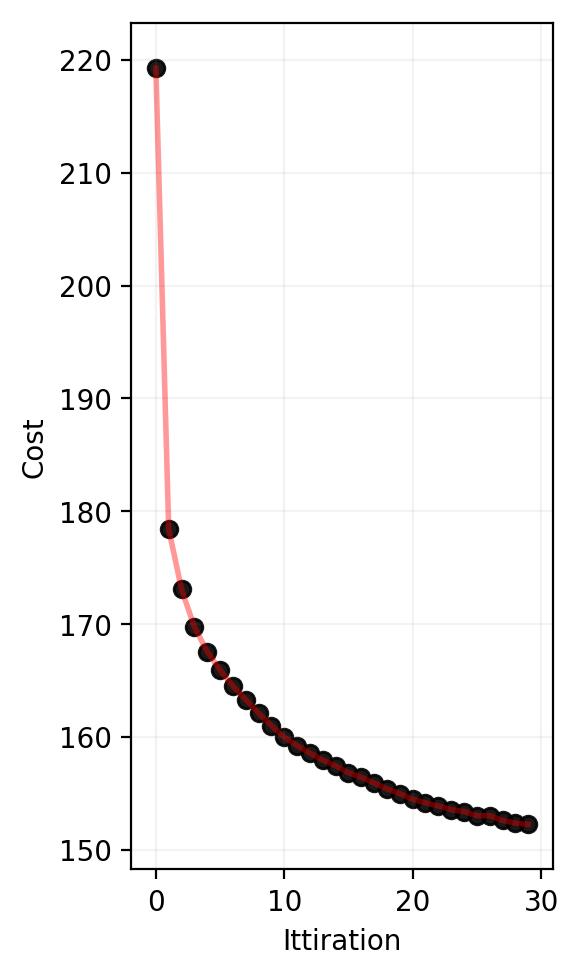

In [59]:
pltotting_cost(cost_plotting)

## Let's look at the results.

In [60]:
x_sample, y_labels = mnist.test.next_batch(100)

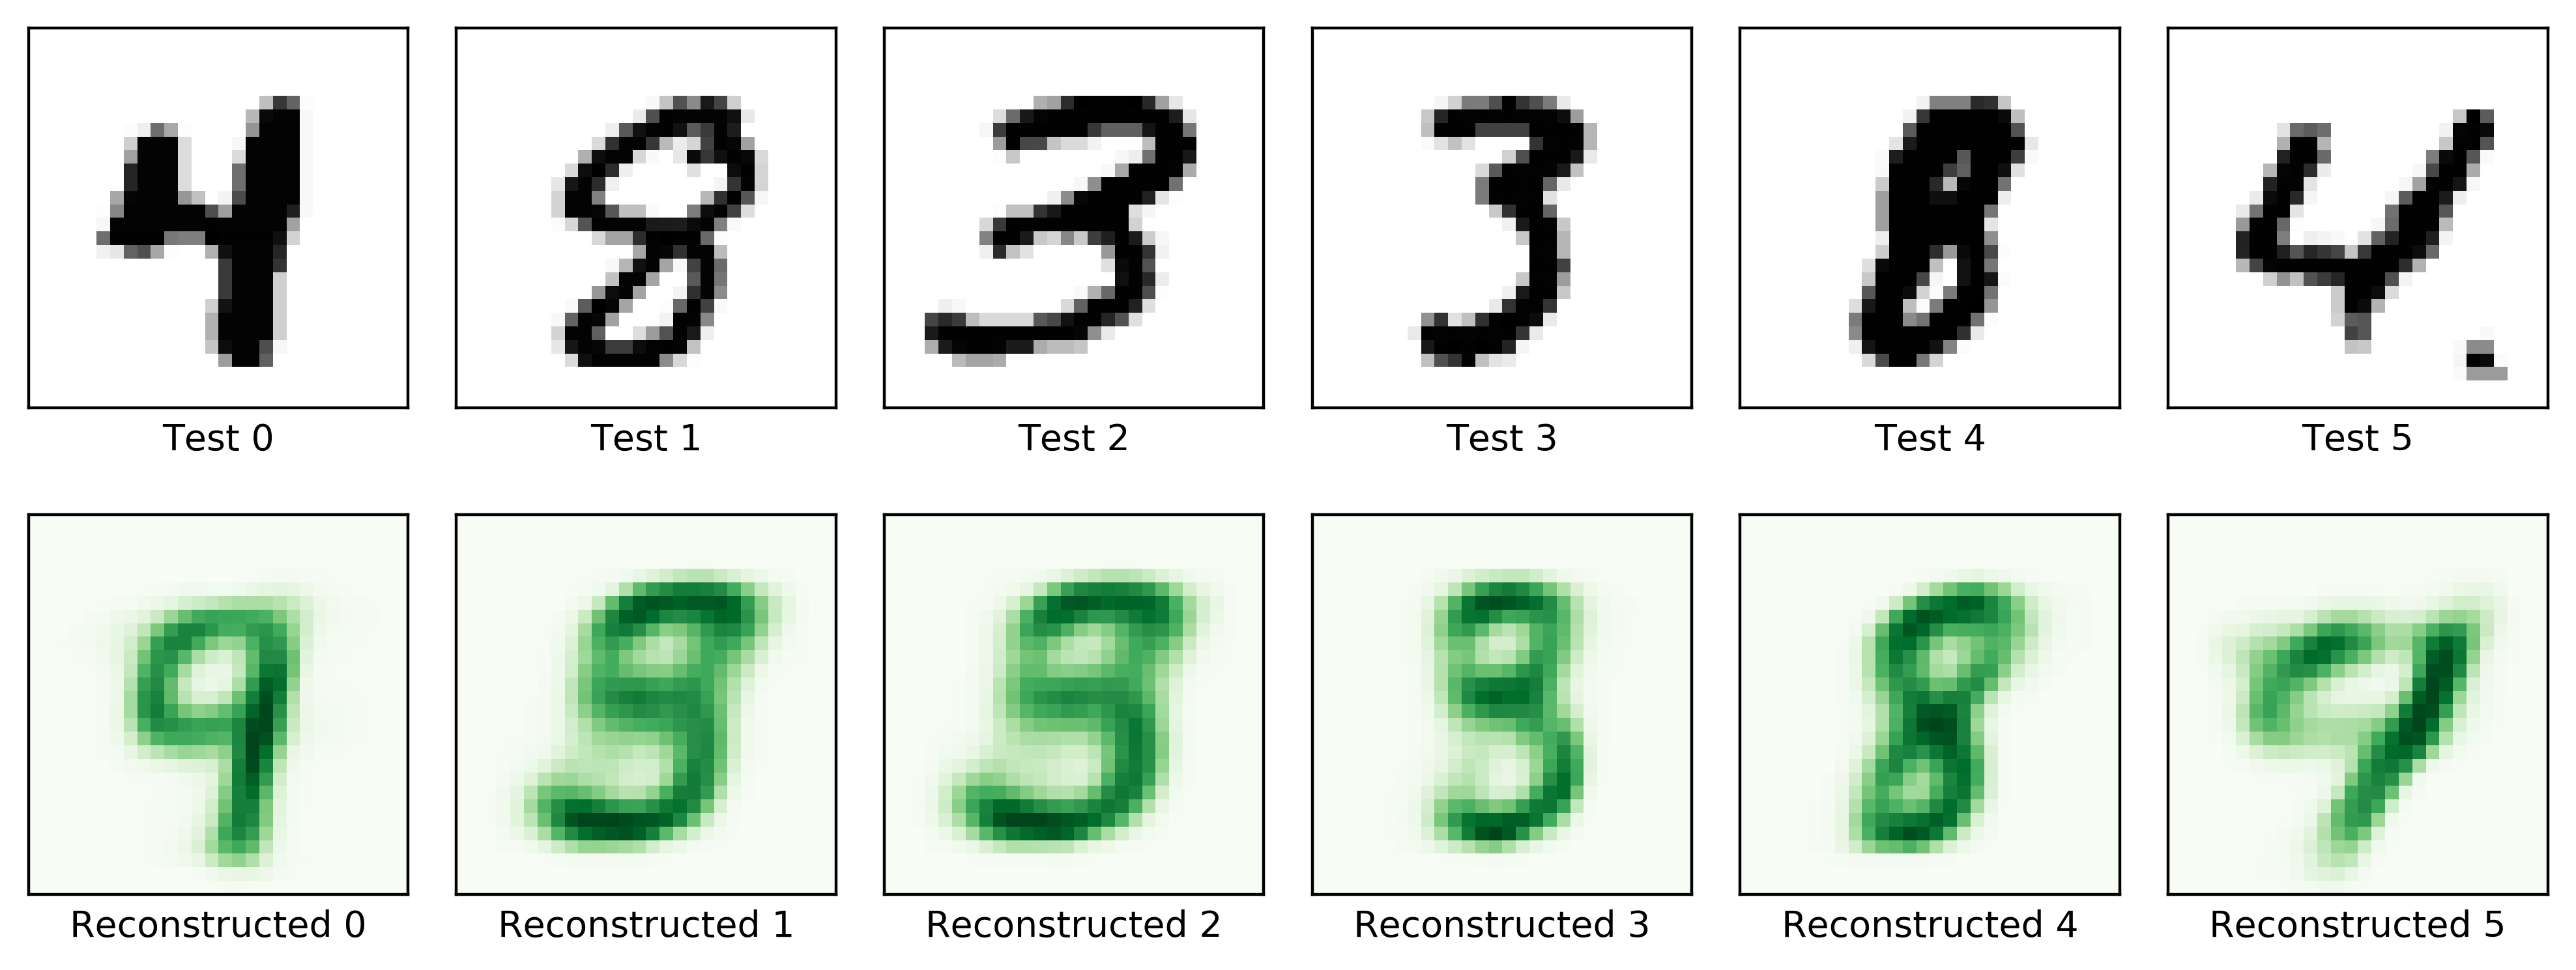

In [61]:
x_reconstruct = va.recons(x_sample)
latent_space_reconstruction(x_sample[5:], x_reconstruct[5:])

In [62]:
x_sample_m, y_labels_m = mnist.test.next_batch(1000)

In [63]:
k=va.latent_space_visulization(x_sample_m)

/Users/yanj11/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


IndexError: index 2 is out of bounds for axis 1 with size 2

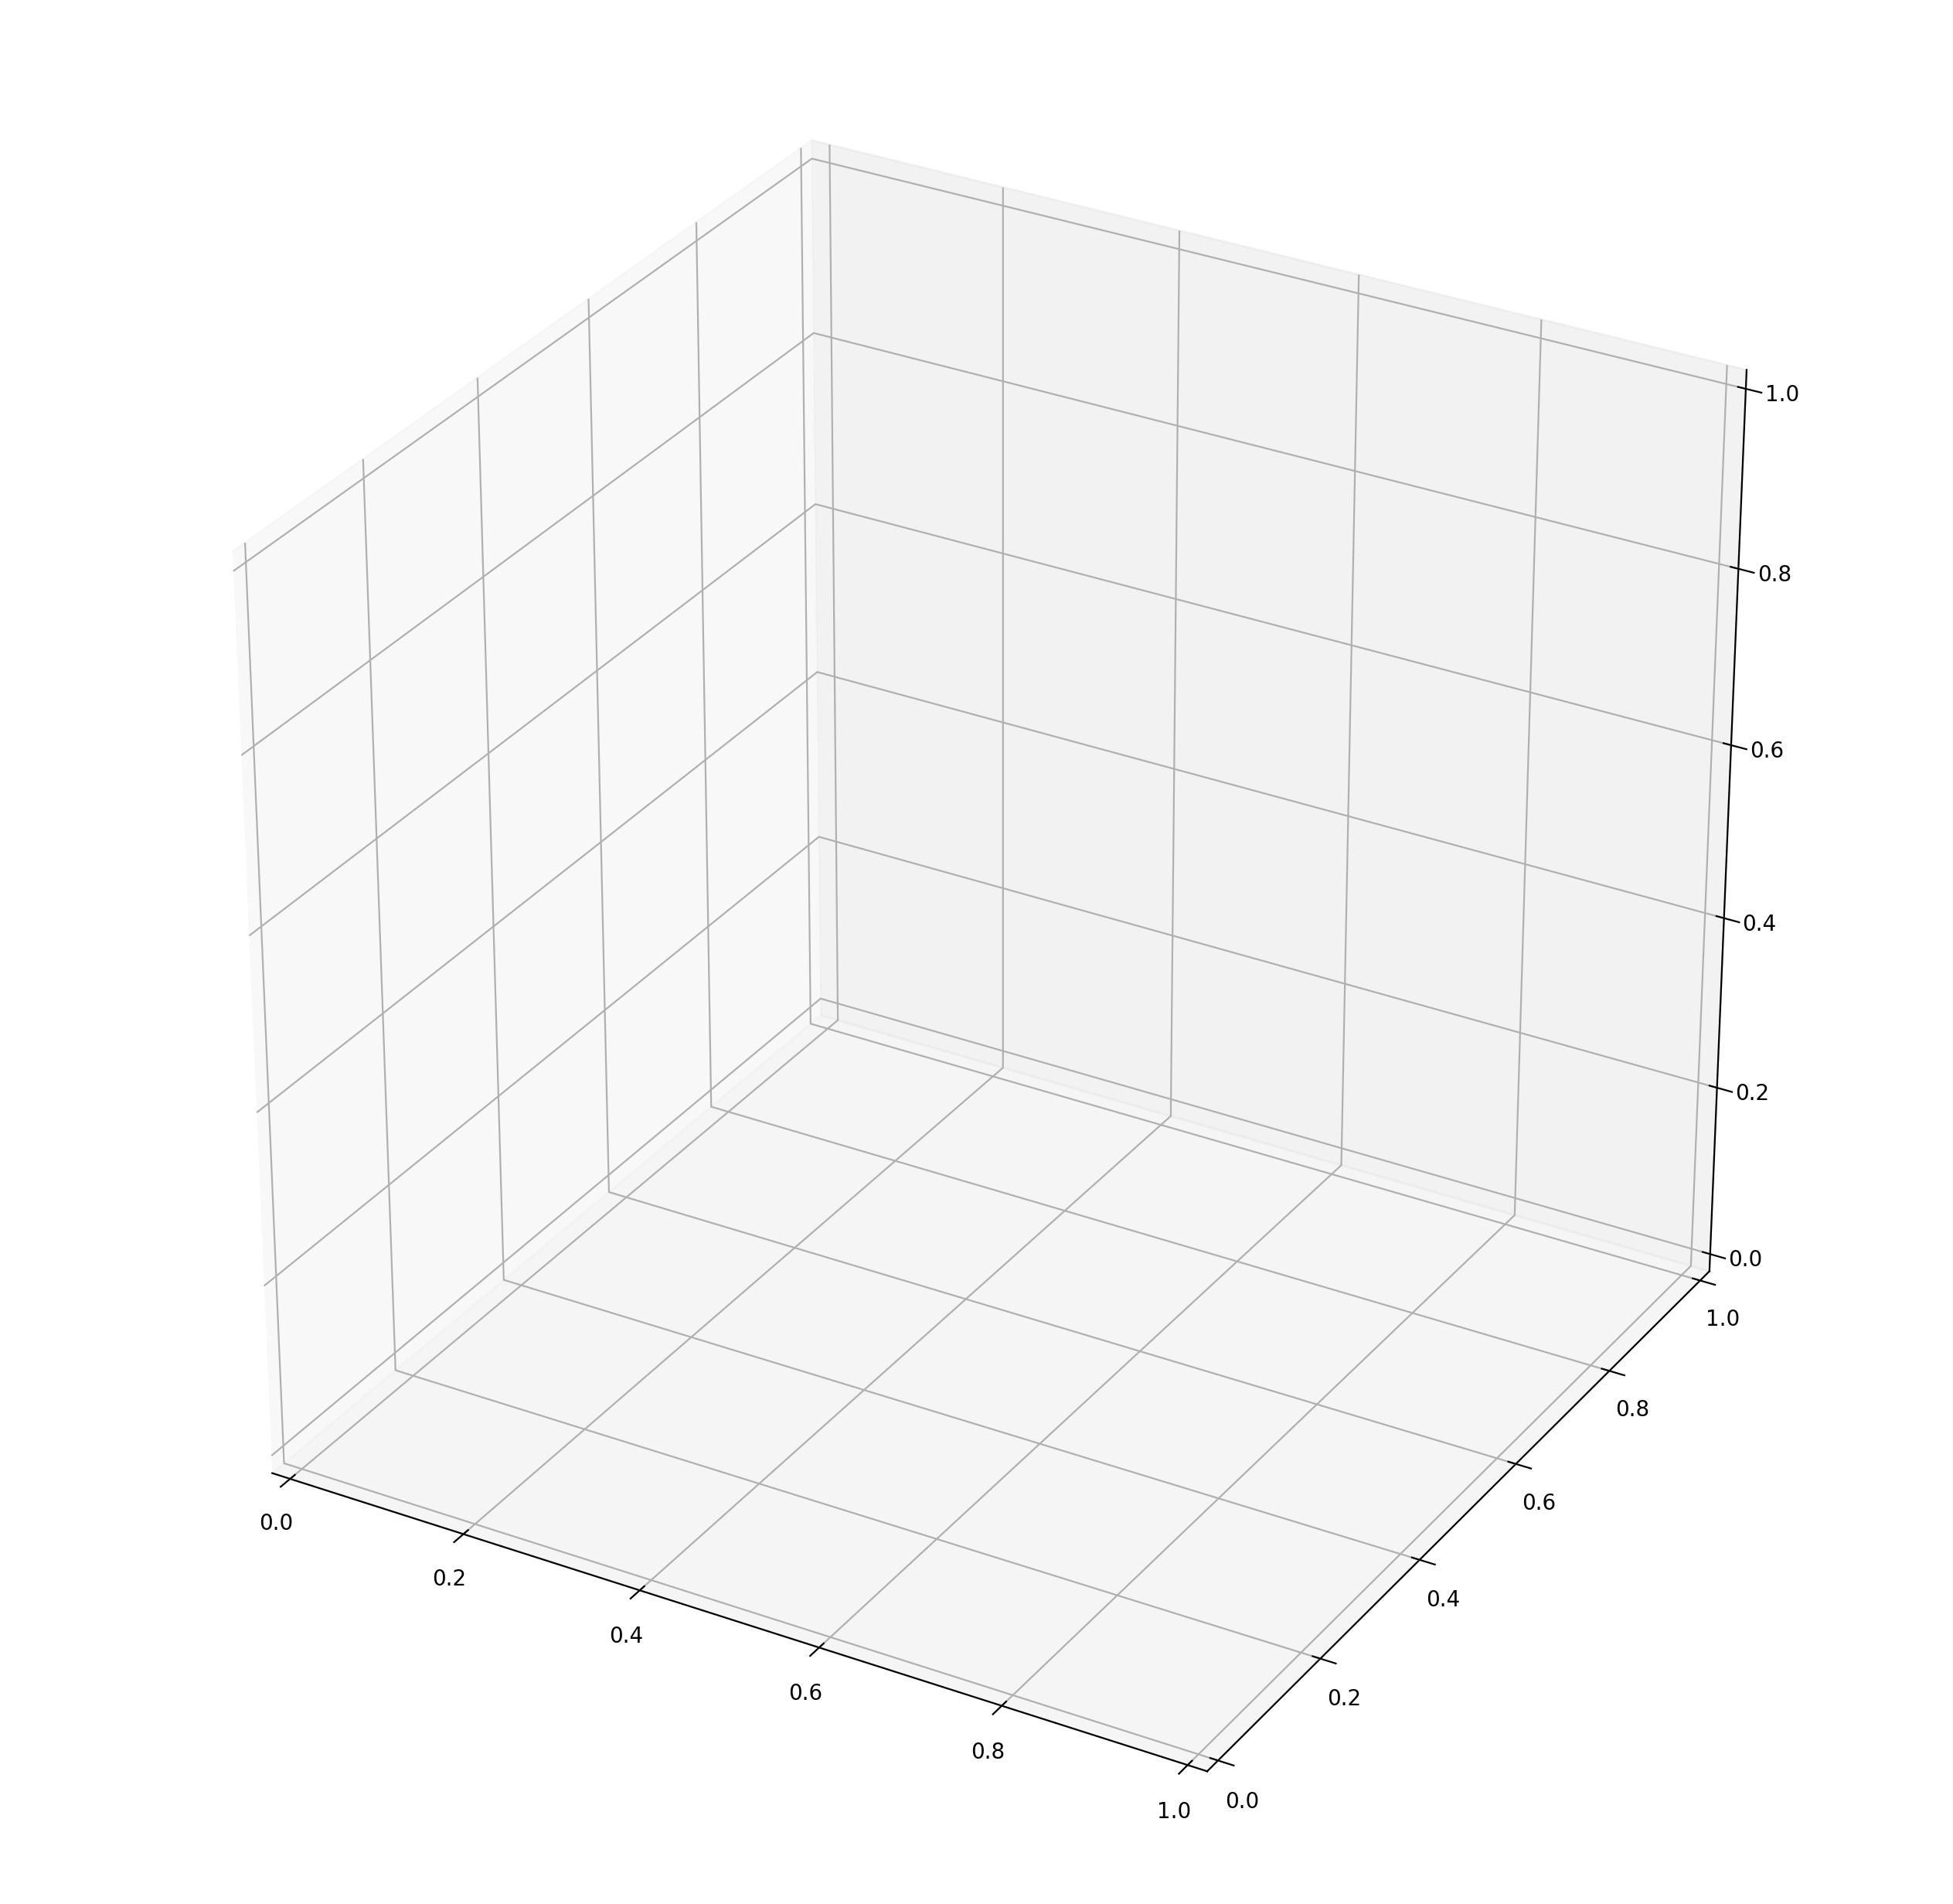

In [64]:
three_d_plotting(k, y_labels_m)

In [33]:
y_labels_m.shape

(1000, 10)